<a href="https://colab.research.google.com/github/kimdonggyu2008/transformer_practice/blob/main/3transformer_chatbot_practice2_%ED%95%9C%EA%B5%AD%EC%96%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

포지셔널 인코딩

RNN에서는 문장을 바로 임베딩 벡터로 변경함

트랜스포머에서는 임의의 값을 더한 후에 입력으로 사용

여기에서는 사인, 코사인값임

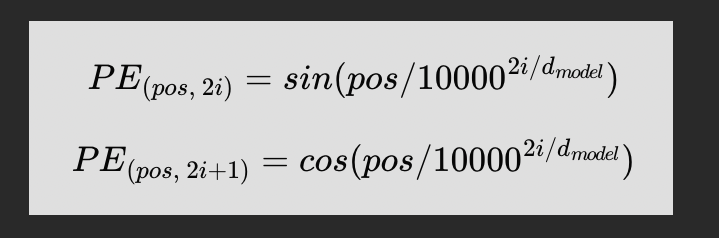

POW함수 = 거듭제곱 POW(밑, 제곱횟수)

CAST = 타입변환 함수 CAST(대상, 변환할 타입)

D_MODEL의 값(임베딩 레이어의 갯수)만큼 순서정보가 저장됨

In [2]:
class PositionalEncoding(tf.keras.layers.Layer): #포지셔널 인코딩

  #포지셔널 인코딩의 초기 선언,
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__() #부모클래스 호출
    self.pos_encoding = self.positional_encoding(position, d_model)

  #위상 결정
  def get_angles(self, position, i, d_model): #위상 추출
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))#사인, 코사인에 들어가는 값
    return position * angles #임베딩 레이어 갯수만큼 위상 나누고, 포지션에 따라 곱함
    #동일 단어라도 위치에 따라서 다른 벡터를 가지게 됨


  def positional_encoding(self, position, d_model): #포지셔널 인코딩 계산
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], #특정 위치 이후 전부 지정
        #이후 각각에 대해서 차원을 추가(하나씩 구분됨)
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],#임베딩 레이어 갯수만큼 분리

        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])#

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])#

    angle_rads = np.zeros(angle_rads.shape)#포지션 갯수 * 임베딩 레이어 갯수
    angle_rads[:, 0::2] = sines #사인 적용
    angle_rads[:, 1::2] = cosines # 코사인 적용
    pos_encoding = tf.constant(angle_rads) #절댓값, 모두 양수로 변경
    pos_encoding = pos_encoding[tf.newaxis, ...] #새로운 차원 추가 1*포지션 갯수  * 임베딩레이어 갯수

    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32) #포지션 인코딩의 타입 변경

  def call(self, inputs): #배치사이즈 * 시퀀스 길이 * 임베딩 레이어 갯수
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :] #원래값 + 홀수, 짝수에 사인코사인 적용된 값 더함

포지션 나누는 갯수, 임베딩 레이어 갯수



(1, 50, 128)
(1, 100, 256)
(1, 100, 128)
(1, 200, 256)


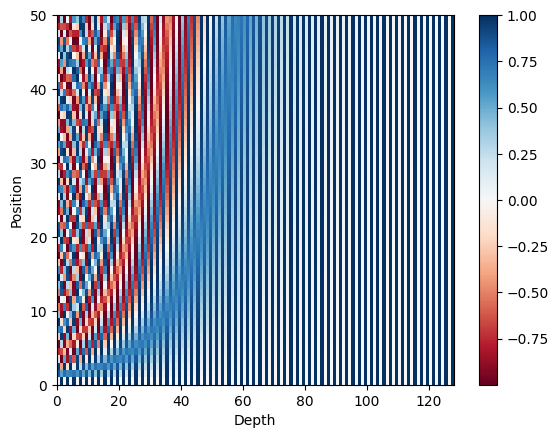

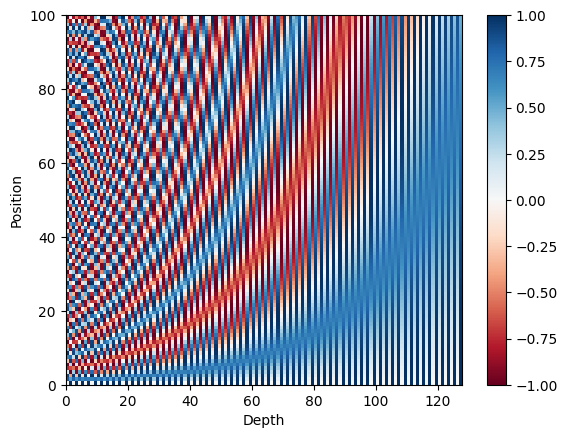

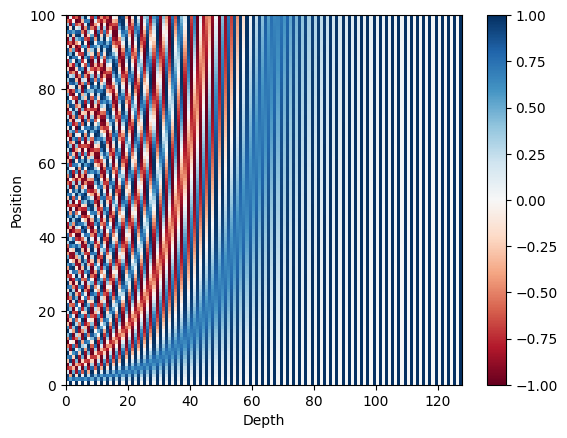

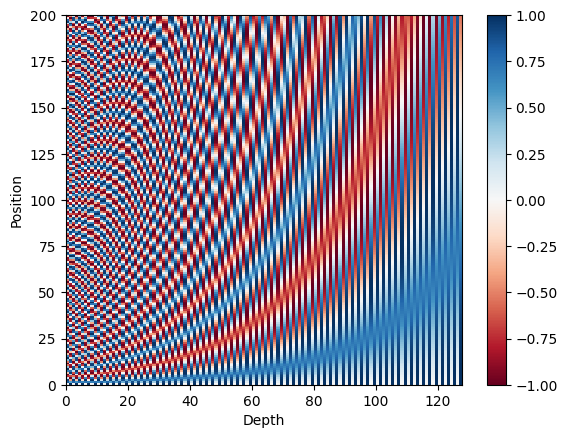

In [3]:
sample_pos_encoding1=PositionalEncoding(50,128)#포지션 갯수, 임베딩 레이어 갯수

sample_pos_encoding2=PositionalEncoding(100,256)#포지션 갯수, 임베딩 레이어 갯수

sample_pos_encoding3=PositionalEncoding(100,128)#포지션 갯수, 임베딩 레이어 갯수

sample_pos_encoding4=PositionalEncoding(200,256)#포지션 갯수, 임베딩 레이어 갯수

#포지션 갯수가 많아질수록 깊이가 깊어짐
#또한 임베딩 레이어 갯수가 늘어날수록 간격이 촘촘?
plt.pcolormesh(sample_pos_encoding1.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

plt.pcolormesh(sample_pos_encoding2.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

plt.pcolormesh(sample_pos_encoding3.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

plt.pcolormesh(sample_pos_encoding4.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 128))
plt.ylabel('Position')
plt.colorbar()
plt.show()

batch_size= 한번에 사용할 데이터 갯수

num_heads= 병렬로 계산할 어텐션층의 갯수

d_model/num_heads = 어텐션 헤드의 차원 갯수

padding_mask는 한번에 볼 크기의 지정

스케일링 = 정규화(0~1로 바꾸는 작업)

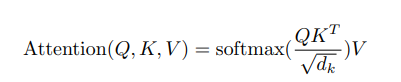

In [4]:
def scaled_dot_product_attention(query, key, value, mask): #어텐션 초기 선언
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)#key텐서 전치, query와 key가 크기가 동일하기에 전치해야 곱이 가능함
  #전치 값들을 통해 내적구함

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32) #키값의 마지막차원?)를 타입변경,플로트로 계산 가능하게 변경
  logits = matmul_qk / tf.math.sqrt(depth)# 각 값들을 루트값으로 나누어 스케일링

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9) #마스크 이외에는 다 0으로 변경

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1) #문장을 따라서 소프트맥스 확인

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

멀티헤드 어텐션



d_model = 임베딩 차원 갯수 지정

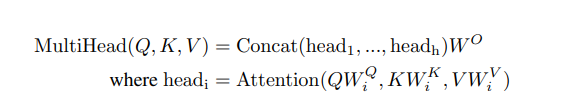

In [5]:
"""
class MultiHeadAttention(tf.keras.layers.Layer): #멀티헤드 어텐션 선언
  def __init__(self,d_model,num_heads,name="multi_head_attention"):
    super(MultiHeadAttention,self).__init__(name=name)
    self.num_heads=num_heads #어텐션 층 갯수
    self.d_model=d_model #임베딩 차원 = 출력 차원 갯수

    assert d_model % self.num_heads==0 #임베딩 차원을 다양한 차원으로 나눌때 안나눠지면 에러뜸

    self.depth=d_model//self.num_heads # 임베딩 차원(표현 정보 수)을 헤드의 수(병렬 어텐션 계산 수)로 나눔

    self.query_dense=tf.keras.layers.Dense(units=d_model)#각각의 밀집레이어에 적용
    self.key_dense=tf.keras.layers.Dense(units=d_model)
    self.value_dense=tf.keras.layers.Dense(units=d_model)

    self.dense=tf.keras.layers.Dense(units=d_model)#임베딩 차원갯수만큼의 밀집레이어 생성


  def split_heads(self,inputs,batch_size): #num_head갯수만큼 입력값 자름
    inputs=tf.reshape(
        inputs,shape=(batch_size,-1,self.num_heads,self.depth))#입력값 텐서의 형태 변경
        #배치사이즈*시퀀스 길이* d_model에서     배치사이즈*넘_헤드*시퀀스 길이 * 깊이로 변경
    return tf.transpose(inputs,perm=[0,2,1,3]) #텐서 순서 변경



  def call(self,inputs):
    query, key, value,mask=inputs['query'],inputs['key'],inputs['value'],inputs['mask'] #각 텐서 표현
    batch_size=tf.shape(query)[0]#크기는 배치사이즈 길이만큼
    #input에서 각각의 값을 추출함, 길이는 모두 동일하기에 쿼리 길이로 저장

    query=self.query_dense(query) #각 데이터에 해당하는 밀집층 통과, 길이는 각 행렬의 문장길이
    key=self.key_dense(key)
    value=self.value_dense(value)

    query=self.split_heads(query,batch_size)#해당 갯수만큼 분리시킴
    key=self.split_heads(key,batch_size)
    value=self.split_heads(value,batch_size)


    #어텐션 모양 = 배치사이즈 * 넘헤드 * 쿼리 시퀀스 길이 * 깊이
    #어텐션 웨이트 모양 = 배치사이즈*넘헤드 * 쿼리 시퀀스 길이 * 키 시퀀스 길이
    scaled_attention,_=scaled_dot_product_attention(query,key,value,mask)
    scaled_attention=tf.transpose(scaled_attention,perm=[0,2,1,3])#전치행렬로 변경

    concat_attention=tf.reshape(scaled_attention,(batch_size,-1,self.d_model)) #헤드 연결?
    #배치 사이즈, 쿼리 문장 길이, 임베딩 차원 갯수

    outputs=self.dense(concat_attention) #해당 데이터들 밀집층 통과

    return outputs


"""
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads #병렬 갯수 - 레이어의 종류 갯수
    self.d_model = d_model#출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64 - 출력표현을 64로 지정한 것
    # 출력 표현을 64개로 최종 출력시키는데, 8개의 레이어로 만들었으므로, 각각 8개씩 담당?
    self.depth = d_model // self.num_heads #따라서 8개의 표현으로 8개의 히든레이어(?)가짐?

    # WQ, WK, WV에 해당하는 밀집층 정의, 각 텐서에 대해 가중치 생성
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):#입력은 쿼리, 키, 밸류 값이고, 배치 사이즈만큼 각각 자름?
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))#배치사이즈*?*병렬 갯수 * 각 레이어별 표현갯수
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):#각각 생성 및 전처리(?)
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0] #모든 크기는 동일하기에 쿼리 값으로 배치사이즈 생성

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads) - 여기선 64/8이므로 8개임
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # 쿼리, 키 묶고 나중에 밸류로 묶어서 컨캣

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,#선형계산까지 끝내고 형태 변경
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [6]:
def create_padding_mask(x): #패딩 마스크 생성
  mask=tf.cast(tf.math.equal(x,0),tf.float32)#모든 값들을 플로트로 변경
  #배치 사이즈, 1,1, key문장 길이
  return mask[:,tf.newaxis,tf.newaxis,:]#배치 사이즈 * 키 시퀀스 길이에서 차원 2개 추가

인코딩 레이어 전체 확인

num_heads = 병렬 갯수 - 레이어의 종류 갯수

d_model = 출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

dff = 피드 포워드 내부 차원크기

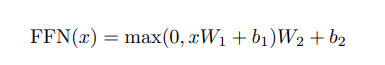

In [7]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"): #인코딩 레이어 생성
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs") #임베딩 길이만큼의 1차원 생성
  #

  # 인코더는 패딩 마스크 사용, 모양은 1*1의 모양가짐
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention( #쿼리, 키, 밸류로 나뉘어진 값들을 인코딩 레이어로 계산
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)#드롭아웃 비율만큼 날림
  attention = tf.keras.layers.LayerNormalization(#결과값 정규화
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층), 선형 분류 2번째
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs) # add&normalization 한번에 계산

  return tf.keras.Model( #모델 만든걸로 반환(완성본)
      inputs=[inputs, padding_mask], outputs=outputs, name=name)



vocab_size = 모델이 다룰 수 있는 전체 어휘수

num_layers = 인코딩 내부 레이어 갯수 지정

dff = 피드 포워드 내부 차원 크기

d_model = 출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

In [8]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs") #쿼리, 키, 밸류로 나뉜 값들 받음(?)

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") #패딩 마스크 선언

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  #다루는 어휘 갯수만큼 각각에 대해서 임베딩(사용여부 및 확인)시킴
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  #각각 스케일링, 그래디언트 안정화(?)
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  #위치 정보 인코딩
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)
  #드롭아웃 적용

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers): #해당 레이어를 여러개 쌓음
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])#각 결과(d_model의 크기 가짐)와 패딩마스크를 계속 넘김

  return tf.keras.Model( #입력값과 패딩 마스크, 출력값을 넘김
      inputs=[inputs, padding_mask], outputs=outputs, name=name)


In [9]:
def create_look_ahead_mask(x):#디코더층에서 토큰 확인
  seq_len=tf.shape(x)[1] #시퀀스 길이 추출
  look_ahead_mask=1-tf.linalg.band_part(tf.ones((seq_len,seq_len)),-1,0)#시퀀스 * 시퀀스 크기의 1로된 행렬
  # 하삼각 행렬을 유지하고 나머지를 0으로 만듦,
  padding_mask=create_padding_mask(x)#위쪽 삼각형만 남긴 마스크 생성
  return tf.maximum(look_ahead_mask,padding_mask) #마스크, 패딩 마스크중에서 큰 것 고름, 둘 다 크기 똑같음


d_model = 출력 표현 갯수

num_heads = 병렬 표현을 위한 레이어 갯수



인코더의 입력값과의 비교


inputs = tf.keras.Input(shape=(None, d_model), name="inputs") #임베딩 길이만큼의 1차원 생성

In [12]:
def decoder_layer(dff,d_model,num_heads,dropout,name="decoder_layer"):
  inputs=tf.keras.Input(shape=(None,d_model),name="inputs") #첫번째 층의 쿼리, 키, 밸류값 입력으로 사용

  enc_outputs=tf.keras.Input(shape=(None,d_model),name='encoder_outputs') #인코더 적용한 값을 디코더에서 사용

  #미래값 숨김(마스크 적용)
  look_ahead_mask=tf.keras.Input(
      shape=(1,None,None),name="look_ahead_mask")#패딩 마스크, 룩어헤드 마스크는 동일할 수 있음
  padding_mask=tf.keras.Input(shape=(1,1,None),name='padding_mask')


  #첫번째 멀티헤드 어텐션, 마스크 적용된 멀티헤드 어텐션
  attention1=MultiHeadAttention(#마스크 값 가지고 멀티헤드 어텐션 실행
      d_model,num_heads,name="attention_1")(inputs={
          'query':inputs,'key':inputs,'value':inputs,
          'mask':look_ahead_mask
        })
  #잔차 연결, 정규화(add&normalization)
  attention1=tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1+inputs) #멀티헤드 어텐션 값+원 입력값을 더해서 기울기 유지
  #또한 정규화 진행



  #두번째 일반 멀티헤드 어텐션
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={#1번에서 나온 값
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })#쿼리값만 가져오고 밸류, 키값은 입력값에서 바로 가져옴

  #드롭아웃, 층 정규화
  attention2=tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2=tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2+attention1)#디코더 레이어 통한 값과 이전 어텐션 값 더함, 정규화를 통해서 1로 유지시킴


  #세번째 서브층,피드포워드 층
  outputs=tf.keras.layers.Dense(units=dff,activation='relu')(attention2) #특징의 복잡화
  outputs=tf.keras.layers.Dense(units=d_model)(outputs) #d_model의 크기만큼 통과

  #
  #드롭아웃 + 잔차연결, 정규화
  outputs=tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs=tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs+attention2)#현재 결과값 + 두번째 멀티헤드 어텐션 결과값 가져와서 더함

  return tf.keras.Model( #디코더 내부모델 반환
      inputs=[inputs,enc_outputs,look_ahead_mask,padding_mask], #각각의 값 반환
      outputs=outputs,
      name=name)

vocab_size = 모델이 다룰 수 있는 전체 어휘수

num_layers = 인코딩 내부 레이어 갯수 지정

dff = 피드 포워드 내부 차원 크기

d_model = 출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

In [13]:
def decoder(vocab_size,num_layers,dff, #디코더 전체 선언
            d_model,num_heads,dropout,
            name='decoder'):
  inputs=tf.keras.Input(shape=(None,),name='inputs')
  enc_outputs=tf.keras.Input(shape=(None,d_model),name='encoder_outputs')
  #인코더의 출력값은 1차원이면서 각 병렬 행렬 갯수만큼 각 값 반환


  #룩어헤드 마스크 선언, 패딩 마스크 선언
  look_ahead_mask=tf.keras.Input(
      shape=(1,None,None),name='look_ahead_mask')
  padding_mask=tf.keras.Input(shape=(1,1,None),name='padding_mask')

  #포지셔널 인코딩 + 드롭아웃
  #입력값에 대해서 각각의 단어로 임베딩시킴
  embeddings=tf.keras.layers.Embedding(vocab_size,d_model)(inputs)
  #각 값들의 루트값만큼 곱해줌
  embeddings*=tf.math.sqrt(tf.cast(d_model,tf.float32))
  #위치 임베딩도 적용(사인, 코사인)
  embeddings=PositionalEncoding(vocab_size,d_model)(embeddings)
  #드롭아웃 적용
  outputs=tf.keras.layers.Dropout(rate=dropout)(embeddings)

  #디코더 num_layers개 생성
  for i in range(num_layers):
    outputs=decoder_layer(dff=dff,d_model=d_model,num_heads=num_heads, #디코더 설정 넘기고 갯수만큼 생성
                          dropout=dropout,name='decoder_layer_{}'.format(i),
                          )(inputs=[outputs,enc_outputs,look_ahead_mask,padding_mask])

  return tf.keras.Model( #모델 만들어서 반환
      inputs=[inputs,enc_outputs,look_ahead_mask,padding_mask],
      outputs=outputs,
      name=name)

트랜스포머 모델 = 인코더 + 디코더 + 스케일드 닷 프로덕트 어텐션


인코더 입력값

inputs = tf.keras.Input(shape=(None,), name="inputs")

padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

인코더 출력값

배치사이즈, 시퀀스 길이, d_model의 형태를 가짐





디코더 입력값

inputs=tf.keras.Input(shape=(None,d_model),name="inputs")

enc_outputs=tf.keras.Input(shape=(None,d_model),name='encoder_outputs')


In [14]:
def transformer(vocab_size,num_layers,dff, #트랜스포머 모델의 총 형태 지정
                d_model,num_heads,dropout,
                name="transformer"):
  #인코더 입력
  inputs=tf.keras.Input(shape=(None,),name="inputs") #(NONE,)의 모양 입력받음

  #디코더 입력
  dec_inputs=tf.keras.Input(shape=(None,),name="dec_inputs")#디코더 입력형태 지정

  #인코더 패딩마스크 생성 후 적용
  enc_padding_mask=tf.keras.layers.Lambda( #인코더 패딩마스크 생성
      create_padding_mask,output_shape=(1,1,None),#인코더 입력에 적용
      name='enc_padding_mask')(inputs)

  #디코더 룩어헤드 마스크 생성 후 적용
  look_ahead_mask=tf.keras.layers.Lambda( #인코더 출력에 적용
      create_look_ahead_mask,output_shape=(1,None,None),
      name='look_ahead_mask')(dec_inputs)

  #디코더 패딩 마스크 생성 후 적용
  #이 경우에는 첫번째 디코딩 레이어를 지난 후, 키, 밸류에만 적용되는 경우인듯?
  dec_padding_mask=tf.keras.layers.Lambda(
      create_padding_mask,output_shape=(1,1,None),
      name='dec_padding_mask')(inputs)

  # 인코더에 입력 문장과 패딩마스크로 실행
  # 또한 나온 결과를 enc_outputs로 저장함
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # enc_outputs를 입력으로 집어넣고,디코더에 적용할 룩어헤드, 패딩마스크까지 넣음
  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  #각 병렬 트랜스포머 모델마다 결과가 나오게 됨
  outputs=tf.keras.layers.Dense(units=vocab_size,name="outputs")(dec_outputs)

  #각 모델마다 나온 결과를 반환함
  return tf.keras.Model(inputs=[inputs,dec_inputs],outputs=outputs,name=name)

모델 실행

vocab_size = 모델이 다룰 수 있는 전체 어휘수

num_layers = 인코딩 내부 서브 레이어 갯수 지정

dff = 피드 포워드 내부 차원 크기

d_model = 출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

num_heads = 병렬로 만들 모델의 갯수

(1, 9000, 128)
(1, 9000, 128)


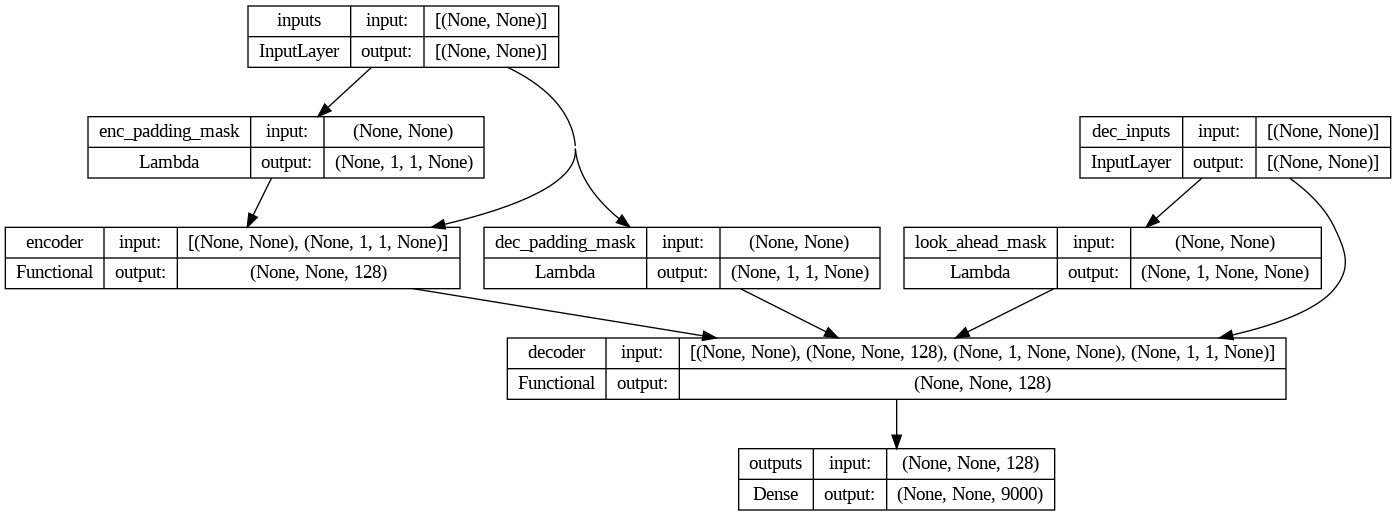

In [15]:
small_transformer = transformer(
    vocab_size = 9000, #사용할 어휘 수
    num_layers = 4, #인코딩 내부 레이어 갯수
    dff = 512, #피드 포워드 내부 레이어갯수
    d_model = 128, #임베딩 레이어 갯수
    num_heads = 4,
    dropout = 0.3,
    name="small_transformer")

tf.keras.utils.plot_model(
    small_transformer, to_file='small_transformer.png', show_shapes=True)

In [16]:
def loss_function(y_true, y_pred): #손실 함수
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1)) #역순으로 재정렬

  loss = tf.keras.losses.SparseCategoricalCrossentropy( #다중 분류
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) #마스크는 일치하지 않는 경우
  loss = tf.multiply(loss, mask) #맞으면 1, 안맞으면 0으로 변화시킴

  return tf.reduce_mean(loss) #일치, 불일치의 평균구함

d_model = 출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

In [92]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step): #일정 범위까지는 arg1을 학습률로, 이후부터는 arg2사용
    step=tf.cast(step,tf.float32)
    #스텝의 제곱근의 역수, 1/루트(원하는 수)의 모양임
    arg1 = tf.math.rsqrt(step) #4000 기준으로 0.015정도 나옴

    #일정 스텝까지는 증가, 이후부터는 크게 감소함
    arg2 = step * (self.warmup_steps**-1.5)

    #학습률은 d_model의 제곱근 역 * arg1과 arg2보다 작은 것에 따라감
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

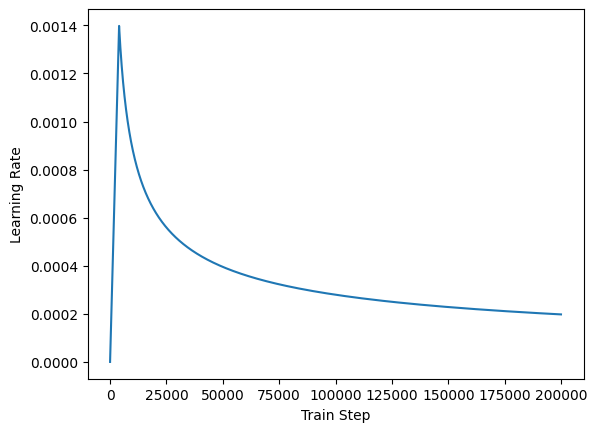

In [93]:
sample_learning_rate = CustomSchedule(d_model=128) #출력 표현 갯수 지정

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32))) #학습횟수에 따른 변화 가능
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

챗봇 구현 파트


In [19]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [20]:

urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatBotData.csv") #데이터셋 다운로드

train_data = pd.read_csv('ChatBotData.csv') #질문, 대답 세트#읽어오기
train_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [ ]:
print(train_data.isnull().sum()) #문제, 대답, 라벨이 없는 경우 체크

In [ ]:
print(len(train_data))

질문,답안에 대해서 특수문자 전처리


In [57]:
questions = []
for sentence in train_data['Q']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence) #특수문자 빈칸으로 변경
    sentence = sentence.strip()
    questions.append(sentence)

In [58]:

answers = []
for sentence in train_data['A']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    answers.append(sentence)

In [37]:
len(questions)

11823

In [ ]:


print(questions[:5])
print(answers[:5])

bpe(바이트 페어 인코딩)

많이 발생한 글자쌍을 찾아서 하나로 합치는 압축 알고리즘

aaaaa를 z로 바꾸는 형식

빈도가 높은 유니그램의 쌍을 하나의 유니그램으로 통합


# dictionary
l o w : 5,  l o w e r : 2,  n e w e s t : 6,  w i d e s t : 3
인 경우
es가 포함되어있을시 9의 코스트로 가장 높은 빈도를 가짐
est로 묶임

그다음은 lo가 7로 묶임

이런방식으로 코스트별로 각 단어를 묶음
# dictionary update!
lo w : 5,
lo w e r : 2,
n e w est : 6,
w i d est : 3

학습이 끝난 후에 lowest가 나타나면 lowest를 단어별로 나누면 low,est로 나누어 인코딩함

subwordtokenizer에 의해 문장 작은 단위로 나누어짐
다른 언어에도 적용가능함

In [23]:
tokenizer=tfds.deprecated.text.SubwordTextEncoder.build_from_corpus( #하나의 단어를 더 작은 단위로 분리시킴
    questions+answers,target_vocab_size=2**13) #질문, 압변을 묶어서 코퍼스로 사용
    #목표어휘 크기 설정 2**13개 = 8192개 어휘 사용, 입력된 단어를 총 8192개로 인식가능

START_TOKEN,END_TOKEN=[tokenizer.vocab_size],[tokenizer.vocab_size+1]#시작 토큰과 엔드토큰의 점수는 총 어휘갯수에 영향을 받음
#스타트와 엔드는 다른 토큰들과는 다르게 특별해야함

VOCAB_SIZE=tokenizer.vocab_size+2 #어휘 크기 #시작, 엔드토큰을 별도로 추가

In [24]:
#시작, 종료 토큰을 제외한 토큰 중 최고값은 vocab_size-1임

print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8178]
종료 토큰 번호 : [8179]
단어 집합의 크기 : 8180


In [25]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[20])))

Tokenized sample question: [5766, 611, 3509, 141, 685, 3747, 849]


In [31]:
print(tokenizer)

<SubwordTextEncoder vocab_size=8178>


In [33]:
sample_string=questions[200] #특정 위치의 데이터를 가져옴

tokenized_string=questions[200]

tokenized_string=tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

original_string=tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [7773, 7954, 125, 418, 209]
기존 문장: 골프 못 치는데


In [36]:
import random

In [41]:
random_values=[random.randint(0,11000) for _ in range(10)]
print(random_values)
for i in range(10):
  sample_strings=questions[random_values[i]]
  tokenized_string=questions[random_values[i]]
  tokenized_string=tokenizer.encode(sample_strings)
  print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

  original_string=tokenizer.decode(tokenized_string)
  print ('기존 문장: {}'.format(original_string))
  print("")

[349, 2237, 1736, 7788, 2329, 10754, 6377, 3165, 10741, 1512]
정수 인코딩 후의 문장 [3134, 74, 5644, 51]
기존 문장: 기념일 또 까먹었어

정수 인코딩 후의 문장 [5273, 11, 6, 242]
기존 문장: 빚이 너무 많아

정수 인코딩 후의 문장 [571, 210, 526, 216]
기존 문장: 몸살 나서 힘들어

정수 인코딩 후의 문장 [303, 448, 1522, 52, 7486, 1049, 858, 708, 2109, 2075, 1]
기존 문장: 일전에 여기서 댓글주고 받던분들 .

정수 인코딩 후의 문장 [4257, 5593]
기존 문장: 삼겹살 냄새

정수 인코딩 후의 문장 [2541, 163, 61, 198, 1193, 36, 8157, 8092, 8111, 7954, 557]
기존 문장: 연예인과 썸 타는 꿈 해몽 좀

정수 인코딩 후의 문장 [5363, 6953, 31, 5847, 1]
기존 문장: 뭔 상황인지 헷갈리네 .

정수 인코딩 후의 문장 [116, 66, 490, 5600, 31, 253]
기존 문장: 여자친구가 왜 화났는지 모르겠어

정수 인코딩 후의 문장 [6573, 27, 45, 4861, 59]
기존 문장: 연애세포가 다 죽었나

정수 인코딩 후의 문장 [342, 1037, 129, 26]
기존 문장: 만두 먹고 싶어



In [34]:
for ts in tokenized_string:
  print('{}'.format(tokenizer.decode([ts])))

골프
 
못 
치
는데


In [35]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

7773 ----> 골프
7954 ---->  
125 ----> 못 
418 ----> 치
209 ----> 는데


In [47]:

print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(questions)))

단어 집합의 크기(Vocab size): 8180
전체 샘플의 수(Number of samples): 11823


원하는 갯수만큼의 표현을 할 수 있게 함

In [53]:
# 최대 길이를 40으로 정의
MAX_LENGTH = 40

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], [] #입력값과 출력값 저장할 배열 선언

  for (sentence1, sentence2) in zip(inputs, outputs): #각각 저장
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1) #각각 추가
    tokenized_outputs.append(sentence2)

  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences( #최대 길이에 맞추기 위해 나머지 길이를 0으로 채움
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences( #똑같이 적용
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs

In [59]:
#print(questions)
#print(answers)
questions,answers=tokenize_and_filter(questions,answers)

In [55]:
print('질문 데이터의 크기(shape) :', questions.shape)
print('답변 데이터의 크기(shape) :', answers.shape)

질문 데이터의 크기(shape) : (11823, 40)
답변 데이터의 크기(shape) : (11823, 40)


In [73]:
#for ts in tokenized_string:
#  print('{}'.format(tokenizer.decode([ts])))
# 0번째 샘플을 임의로 출력
#print(tokenizer.decode(len(questions.all)))
print(questions[0])

print(answers[0])

[8178 7915 4207 3060   41 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


실 사용을 위한 토큰 제거

tf.data.dataset 하위 메서드

.from_tensor_slices(입력값)
- 주어진 값들을 하나씩 쪼갬

.repeat(n)
- n회 반복해서 붙임

.skip(n)
- n회까지 생략하고 나머지만 출력됨

.batch(n)
- dataset을 n개의 batch로 쪼갬

.shuffle(buffer_size,seed=None,reshuffle_each_iteration=None)
- buffer_size만큼 섞음
- 일반적으로는 전체 데이터셋보다 큰 batch_size가 이상적임

In [126]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': answers[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache() #캐시에 저장
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [127]:

# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(answers[0]) # 기존 샘플
print(answers[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(answers[:1][:, 1:]) #

[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
[[8178 3844   74 7894    1 8179    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
[[3844   74 7894    1 8179    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


In [125]:
print(dataset)

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


vocab_size = 모델이 다룰 수 있는 전체 어휘수

num_layers = 인코딩 내부 서브 레이어 갯수 지정

dff = 피드 포워드 내부 차원 크기

d_model = 출력 차원(임베딩 레이어 갯수) - 출력 표현의 갯수

num_heads = 병렬로 만들 모델의 갯수



def transformer(vocab_size,num_layers,dff,                d_model,num_heads,dropout,name="transformer"):


In [114]:
for inputs,targets in dataset.take(1):
  print(len(inputs))
  print(len(targets))


2
1


In [128]:
#tf.keras.backend.clear_session() #초기화, 데이터셋도 초기화된듯?

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

#트랜스포머 생성
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(1, 8180, 256)
(1, 8180, 256)


In [129]:
MAX_LENGTH = 40 #다룰 문장의 최대 길이는 40

learning_rate = CustomSchedule(D_MODEL) #학습률 스케줄 조정

#for i in learning_rate:
#  print(i)
#plt.plot(learning_rate)
#plt.ylabel("Learning Rate")
#plt.xlabel("Train Step")

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [138]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [140]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #조기 종료 함수 선언
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction,cp_callback]

In [131]:
# 코드 호환성을 위한 분기
use_colab = True
assert use_colab in [True, False]

In [135]:
# the save point
import os
if use_colab:
    checkpoint_dir ='./content/drive/MyDrive/코딩공부/transformer_chatbot/check_chatbot'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    else:
      checkpoint_dir='transformer_chatbot/check_chatbot'

In [133]:
print(dataset.take(5))

<_TakeDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


In [142]:
EPOCHS=50

#history=model.fit_generator(dataset,epochs=EPOCHS)
history=model.fit(dataset,epochs=EPOCHS,callbacks=callbacks)

Epoch 1/50
185/185 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.1738

185/185 [==============================] - 12s 64ms/step - loss: 0.0056 - accuracy: 0.1738 - lr: 6.4348e-04
Epoch 2/50
185/185 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.1737

185/185 [==============================] - 11s 60ms/step - loss: 0.0055 - accuracy: 0.1737 - lr: 6.3726e-04
Epoch 3/50
185/185 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.1738

185/185 [==============================] - 11s 59ms/step - loss: 0.0053 - accuracy: 0.1738 - lr: 6.3122e-04
Epoch 4/50
185/185 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.1738

185/185 [==============================] - 11s 60ms/step - loss: 0.0052 - accuracy: 0.1738 - lr: 6.2534e-04
Epoch 5/50
185/185 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.1739

185/185 [==============================] - 11s 57ms/step - loss: 0.0049 - accuracy: 0.1739 - lr: 6.1963e-04
Epoch 6/50
184/185 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.1740

185/185 [==============================] - 11s 58ms/step - loss: 0.0043 - accuracy: 0.1741 - lr: 6.1407e-04
Epoch 7/50
185/185 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.1740

185/185 [==============================] - 11s 59ms/step - loss: 0.0044 - accuracy: 0.1740 - lr: 6.0866e-04
Epoch 8/50
184/185 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.1741

185/185 [==============================] - 12s 65ms/step - loss: 0.0042 - accuracy: 0.1740 - lr: 6.0339e-04
Epoch 9/50
185/185 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.1742

185/185 [==============================] - 11s 58ms/step - loss: 0.0039 - accuracy: 0.1742 - lr: 5.9826e-04
Epoch 10/50
184/185 [============================>.] - ETA: 0s - loss: 0.0043 - accuracy: 0.1741

185/185 [==============================] - 10s 57ms/step - loss: 0.0043 - accuracy: 0.1741 - lr: 5.9325e-04
Epoch 11/50
184/185 [============================>.] - ETA: 0s - loss: 0.0042 - accuracy: 0.1740

185/185 [==============================] - 11s 59ms/step - loss: 0.0042 - accuracy: 0.1740 - lr: 5.8837e-04
Epoch 12/50
184/185 [============================>.] - ETA: 0s - loss: 0.0040 - accuracy: 0.1741

185/185 [==============================] - 11s 59ms/step - loss: 0.0040 - accuracy: 0.1741 - lr: 5.8360e-04
Epoch 13/50
185/185 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.1741

185/185 [==============================] - 11s 59ms/step - loss: 0.0039 - accuracy: 0.1741 - lr: 5.7895e-04
Epoch 14/50
185/185 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.1741

185/185 [==============================] - 11s 57ms/step - loss: 0.0037 - accuracy: 0.1741 - lr: 5.7441e-04
Epoch 15/50
184/185 [============================>.] - ETA: 0s - loss: 0.0036 - accuracy: 0.1741

185/185 [==============================] - 11s 59ms/step - loss: 0.0037 - accuracy: 0.1741 - lr: 5.6997e-04
Epoch 16/50
185/185 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.1741

185/185 [==============================] - 11s 59ms/step - loss: 0.0036 - accuracy: 0.1741 - lr: 5.6564e-04
Epoch 17/50
185/185 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 0.1742

185/185 [==============================] - 11s 60ms/step - loss: 0.0037 - accuracy: 0.1742 - lr: 5.6140e-04
Epoch 18/50
185/185 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.1742

185/185 [==============================] - 11s 57ms/step - loss: 0.0033 - accuracy: 0.1742 - lr: 5.5726e-04
Epoch 19/50
184/185 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.1742

185/185 [==============================] - 11s 59ms/step - loss: 0.0034 - accuracy: 0.1742 - lr: 5.5321e-04
Epoch 20/50
185/185 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.1743

185/185 [==============================] - 11s 60ms/step - loss: 0.0030 - accuracy: 0.1743 - lr: 5.4924e-04
Epoch 21/50
184/185 [============================>.] - ETA: 0s - loss: 0.0033 - accuracy: 0.1743

185/185 [==============================] - 11s 60ms/step - loss: 0.0033 - accuracy: 0.1742 - lr: 5.4536e-04
Epoch 22/50
185/185 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.1743

185/185 [==============================] - 11s 60ms/step - loss: 0.0030 - accuracy: 0.1743 - lr: 5.4156e-04
Epoch 23/50
185/185 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.1743

185/185 [==============================] - 11s 62ms/step - loss: 0.0032 - accuracy: 0.1743 - lr: 5.3783e-04
Epoch 24/50
185/185 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.1743

185/185 [==============================] - 11s 58ms/step - loss: 0.0031 - accuracy: 0.1743 - lr: 5.3419e-04
Epoch 25/50
185/185 [==============================] - ETA: 0s - loss: 0.0031 - accuracy: 0.1742

185/185 [==============================] - 11s 60ms/step - loss: 0.0031 - accuracy: 0.1742 - lr: 5.3061e-04
Epoch 26/50
184/185 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.1743

185/185 [==============================] - 12s 63ms/step - loss: 0.0029 - accuracy: 0.1743 - lr: 5.2711e-04
Epoch 27/50
185/185 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 0.1742

185/185 [==============================] - 11s 60ms/step - loss: 0.0030 - accuracy: 0.1742 - lr: 5.2368e-04
Epoch 28/50
185/185 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.1743

185/185 [==============================] - 11s 59ms/step - loss: 0.0028 - accuracy: 0.1743 - lr: 5.2031e-04
Epoch 29/50
184/185 [============================>.] - ETA: 0s - loss: 0.0025 - accuracy: 0.1743

185/185 [==============================] - 11s 60ms/step - loss: 0.0025 - accuracy: 0.1744 - lr: 5.1701e-04
Epoch 30/50
185/185 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.1743

185/185 [==============================] - 11s 60ms/step - loss: 0.0027 - accuracy: 0.1743 - lr: 5.1376e-04
Epoch 31/50
184/185 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.1743

185/185 [==============================] - 11s 59ms/step - loss: 0.0027 - accuracy: 0.1743 - lr: 5.1058e-04
Epoch 32/50
184/185 [============================>.] - ETA: 0s - loss: 0.0027 - accuracy: 0.1743

185/185 [==============================] - 11s 58ms/step - loss: 0.0027 - accuracy: 0.1743 - lr: 5.0746e-04
Epoch 33/50
185/185 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 0.1743

185/185 [==============================] - 11s 62ms/step - loss: 0.0027 - accuracy: 0.1743 - lr: 5.0439e-04
Epoch 34/50
185/185 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.1744

185/185 [==============================] - 11s 61ms/step - loss: 0.0024 - accuracy: 0.1744 - lr: 5.0138e-04
Epoch 35/50
185/185 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.1744

185/185 [==============================] - 11s 57ms/step - loss: 0.0024 - accuracy: 0.1744 - lr: 4.9842e-04
Epoch 36/50
184/185 [============================>.] - ETA: 0s - loss: 0.0024 - accuracy: 0.1743

185/185 [==============================] - 11s 59ms/step - loss: 0.0024 - accuracy: 0.1743 - lr: 4.9552e-04
Epoch 37/50
185/185 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.1743

185/185 [==============================] - 12s 64ms/step - loss: 0.0025 - accuracy: 0.1743 - lr: 4.9266e-04
Epoch 38/50
185/185 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.1744

185/185 [==============================] - 11s 59ms/step - loss: 0.0023 - accuracy: 0.1744 - lr: 4.8985e-04
Epoch 39/50
184/185 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.1744

185/185 [==============================] - 11s 57ms/step - loss: 0.0022 - accuracy: 0.1744 - lr: 4.8709e-04
Epoch 40/50
184/185 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.1743

185/185 [==============================] - 11s 60ms/step - loss: 0.0023 - accuracy: 0.1743 - lr: 4.8438e-04
Epoch 41/50
184/185 [============================>.] - ETA: 0s - loss: 0.0023 - accuracy: 0.1743

185/185 [==============================] - 11s 61ms/step - loss: 0.0023 - accuracy: 0.1743 - lr: 4.8171e-04
Epoch 42/50
185/185 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 0.1744

185/185 [==============================] - 11s 58ms/step - loss: 0.0022 - accuracy: 0.1744 - lr: 4.7909e-04
Epoch 43/50
184/185 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.1745

185/185 [==============================] - 11s 60ms/step - loss: 0.0021 - accuracy: 0.1744 - lr: 4.7650e-04
Epoch 44/50
185/185 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.1744

185/185 [==============================] - 11s 60ms/step - loss: 0.0021 - accuracy: 0.1744 - lr: 4.7396e-04
Epoch 45/50
185/185 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.1745

185/185 [==============================] - 11s 58ms/step - loss: 0.0020 - accuracy: 0.1745 - lr: 4.7146e-04
Epoch 46/50
184/185 [============================>.] - ETA: 0s - loss: 0.0021 - accuracy: 0.1744

185/185 [==============================] - 11s 59ms/step - loss: 0.0021 - accuracy: 0.1744 - lr: 4.6900e-04
Epoch 47/50
185/185 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.1744

185/185 [==============================] - 11s 59ms/step - loss: 0.0021 - accuracy: 0.1744 - lr: 4.6657e-04
Epoch 48/50
184/185 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.1744

185/185 [==============================] - 11s 60ms/step - loss: 0.0018 - accuracy: 0.1744 - lr: 4.6419e-04
Epoch 49/50
184/185 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.1744

185/185 [==============================] - 11s 59ms/step - loss: 0.0019 - accuracy: 0.1744 - lr: 4.6184e-04
Epoch 50/50
184/185 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.1744

185/185 [==============================] - 11s 59ms/step - loss: 0.0020 - accuracy: 0.1744 - lr: 4.5952e-04


In [147]:
print(history.history)

{'loss': [0.005565090104937553, 0.005546218249946833, 0.005290217697620392, 0.0052110422402620316, 0.004921609535813332, 0.0043417830020189285, 0.004416355863213539, 0.004230610094964504, 0.003904336364939809, 0.00425261165946722, 0.004207557067275047, 0.004007644020020962, 0.003942124079912901, 0.0037468655500561, 0.0036595240235328674, 0.0035577358212321997, 0.0036622651387006044, 0.0033258101902902126, 0.0033655506558716297, 0.0030048091430217028, 0.003302827011793852, 0.003027676371857524, 0.003244805848225951, 0.0031080867629498243, 0.0031227401923388243, 0.002932431409135461, 0.0030132185202091932, 0.0027593118138611317, 0.0025144885294139385, 0.0026955781504511833, 0.0026866523548960686, 0.0027044995222240686, 0.0026769377291202545, 0.0024380942340940237, 0.002401283010840416, 0.0024275064934045076, 0.0024684418458491564, 0.0023014277685433626, 0.002235204679891467, 0.0023415463510900736, 0.002257163869217038, 0.0021790408063679934, 0.0021495535038411617, 0.002083316445350647, 0

In [154]:
def evaluate(sentence): #평가
  sentence=preprocess_sentence(sentence) #주어진 문장 분석

  sentence=tf.expand_dims(#시작 토큰, 인코딩 된 주어진 문장, 엔드토큰 으로 변경
      START_TOKEN+tokenizer.encode(sentence)+END_TOKEN,axis=0)
  output=tf.expand_dims(START_TOKEN,0) #뒤쪽에 남은 공간에 0으로 채워넣음(패딩)

  for i in range(MAX_LENGTH): #학습된 모델을 통해 각 텐서마다 하나씩 추가로 만들어냄
    predictions=model(inputs=[sentence,output],training=False) #평가모드로 진행

    predictions=predictions[:,-1:,:]#다음 말을 예측하기위해 현재 가장 마지막 말을 씀
    predicted_id=tf.cast(tf.argmax(predictions,axis=-1),tf.int32)#예측된 값을 int형으로 변경

    if tf.equal(predicted_id,END_TOKEN[0]):#엔딩이면 끝냄
      break

    output=tf.concat([output,predicted_id],axis=-1) #결과로 나온 말들을 모두 합침
  return tf.squeeze(output,axis=0)#차원을 줄여서 1차원의 토큰들로 변경함


def predict(sentence): #문장 입력받아서 evaluate로 돌림
  prediction=evaluate(sentence) #주어진 문장을 예측기로 넣음

  predicted_sentence=tokenizer.decode([i for i in prediction if i<tokenizer.vocab_size])#나온 결과를 디코더로 다시 말로 바꿈
  print('Input: {}'.format(sentence))
  print('Output: {}'.format(predicted_sentence))

  return predicted_sentence

In [152]:
def preprocess_sentence(sentence): #들어오는 문장의 부호 제거
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [155]:
output=predict("배고파")

Input: 배고파
Output: 뭐 좀 챙겨드세요 .


In [157]:
output=predict("오늘 뭐하지")

Input: 오늘 뭐하지
Output: 뭘 입어도 예뻐요 .


In [158]:
output=predict("가나다라마바사아자차카타파하")

Input: 가나다라마바사아자차카타파하
Output: 끝이 다가옴을 직감하기도 해요 .


In [159]:
output=predict("으하하하하")

Input: 으하하하하
Output: 짜증날만 해요 .


In [163]:
output=predict("게임하고 싶어")

Input: 게임하고 싶어
Output: 게임하세요 !


In [168]:
output=predict("HELLO WORLD")

Input: HELLO WORLD
Output: 적성에 맞는 사람이 있죠 .
